In [1]:
import arviz as az
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm3
import pymc4 as pm4
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pm3.set_tt_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

az.style.use('arviz-darkgrid')
dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

## Utility functions

In [3]:
def get_bounds(pm3_samples, pm4_samples):
    x_max, y_max = 0, 0
    samples = itertools.chain(pm3_samples.values(), pm4_samples.values())
    for x_draws, y_draws in samples:
        x_max = max(x_max, np.abs(x_draws).max())
        y_max = max(y_max, np.abs(y_draws).max())
    top = max(x_max, y_max)
    return (-top, top)


def plot_approx(engine, samples, bounds):
    fig, axes = plt.subplots(1, 3, figsize=(13.5, 4), squeeze=False, sharey=True)
    fig.suptitle(engine, fontsize=20, y=1.03)
    for (label, (x, y)), ax in zip(samples.items(), axes.ravel()):
        ax.plot(x, y, 'o', alpha=0.5)
        ax.set_title(" ".join(label.split("_")).title())
        ax.axes.set_xlim(bounds)
        ax.axes.set_ylim(bounds)

## 2-d Gaussian

In [4]:
mu = np.zeros(2, dtype=np.float32)
cov = np.array([[1e-2, 0.], [0., 1e2]], dtype=np.float32)
iterations = 30000
N = 1000
multivariate_samples = np.random.multivariate_normal(mu, cov, size=N)

pm3_samples, pm4_samples = dict(), dict()
pm3_samples['Ground Truth'] = pm4_samples['Ground Truth'] = (multivariate_samples[:, 0], multivariate_samples[:, 1])
methods = ['advi', 'fullrank_advi']

pm3_opt = pm3.adagrad(learning_rate=0.1)
pm4_opt = pm4.adagrad(learning_rate=0.1)

In [5]:
# PyMC3

for method in methods:
    with pm3.Model() as model:
        density = pm3.MvNormal('density', mu, cov, shape=2)
        trace = pm3.fit(n=iterations, method=method, obj_optimizer=pm3_opt)
        x, y = trace.sample(N)['density'].T
        pm3_samples[method] = (x, y)

Finished [100%]: Average Loss = 0.0017398


Finished [100%]: Average Loss = 0.0015137


In [6]:
# PyMC4

@pm4.model
def model():
    density = yield pm4.MvNormal('density', mu, cov)
    
for method in methods:
    trace = pm4.fit(model(), num_steps=iterations, method=method, optimizer=pm4_opt)
    samples = trace.approximation.sample(N)
    samples = np.squeeze(samples.posterior['model/density'].values, axis=0)
    pm4_samples[method] = (samples[:, 0], samples[:, 1])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


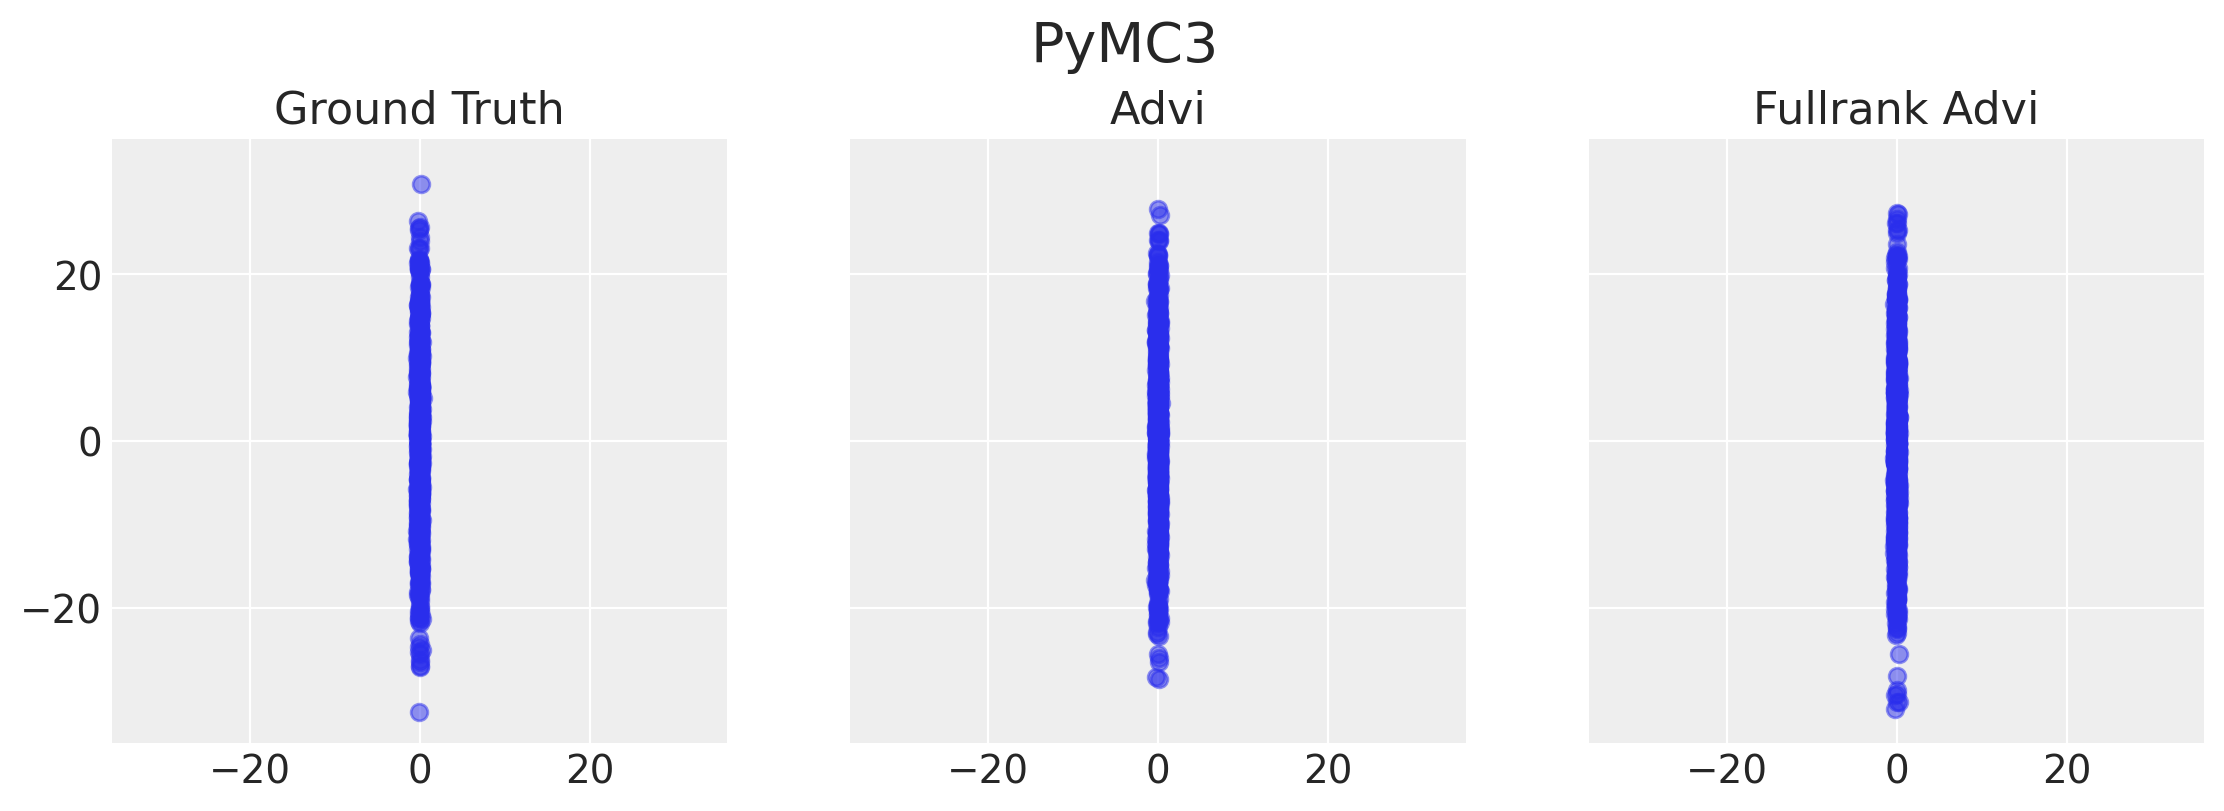

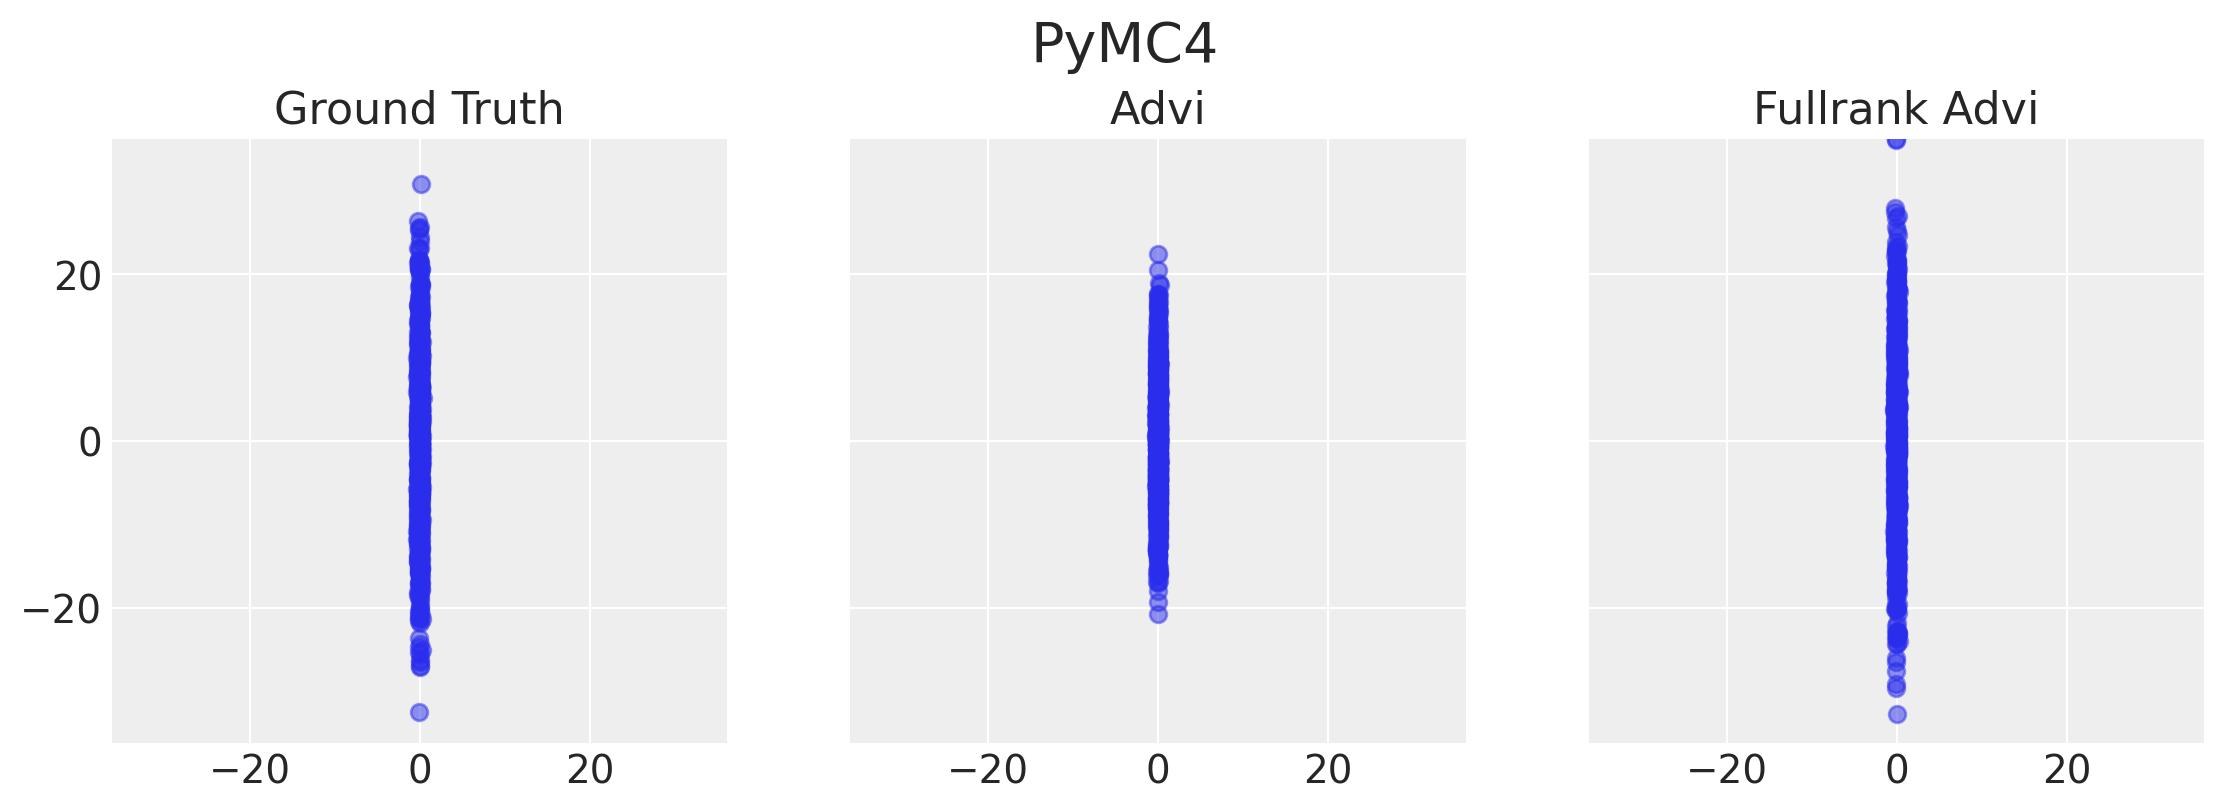

In [7]:
# Plots

bounds = get_bounds(pm3_samples, pm4_samples)
plot_approx('PyMC3', pm3_samples, bounds)
plot_approx('PyMC4', pm4_samples, bounds)

## Strongly correlated Gaussian

In [8]:
mu = np.zeros(2, dtype=np.float32)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]], dtype=np.float32)
iterations = 30000
N = 1000
multivariate_samples = np.random.multivariate_normal(mu, cov, size=N)

pm3_samples, pm4_samples = dict(), dict()
pm3_samples['Ground Truth'] = pm4_samples['Ground Truth'] = (multivariate_samples[:, 0], multivariate_samples[:, 1])
methods = ['advi', 'fullrank_advi']

In [9]:
# PyMC3
# On experimenting, pm3.adam gives nan

for method in methods:
    with pm3.Model() as model:
        density = pm3.MvNormal('density', mu, cov, shape=2)
        trace = pm3.fit(n=iterations, method=method, obj_optimizer=pm3_opt)
        x, y = trace.sample(N)['density'].T
        pm3_samples[method] = (x, y)

Finished [100%]: Average Loss = 2.7421


Finished [100%]: Average Loss = 0.37869


In [10]:
# PyMC4

@pm4.model
def model():
    density = yield pm4.MvNormal('density', mu, cov)
    
for method in methods:
    trace = pm4.fit(model(), num_steps=iterations, method=method, optimizer=pm4.adam(learning_rate=0.1))
    samples = trace.approximation.sample(N)
    samples = np.squeeze(samples.posterior['model/density'].values, axis=0)
    pm4_samples[method] = (samples[:, 0], samples[:, 1])

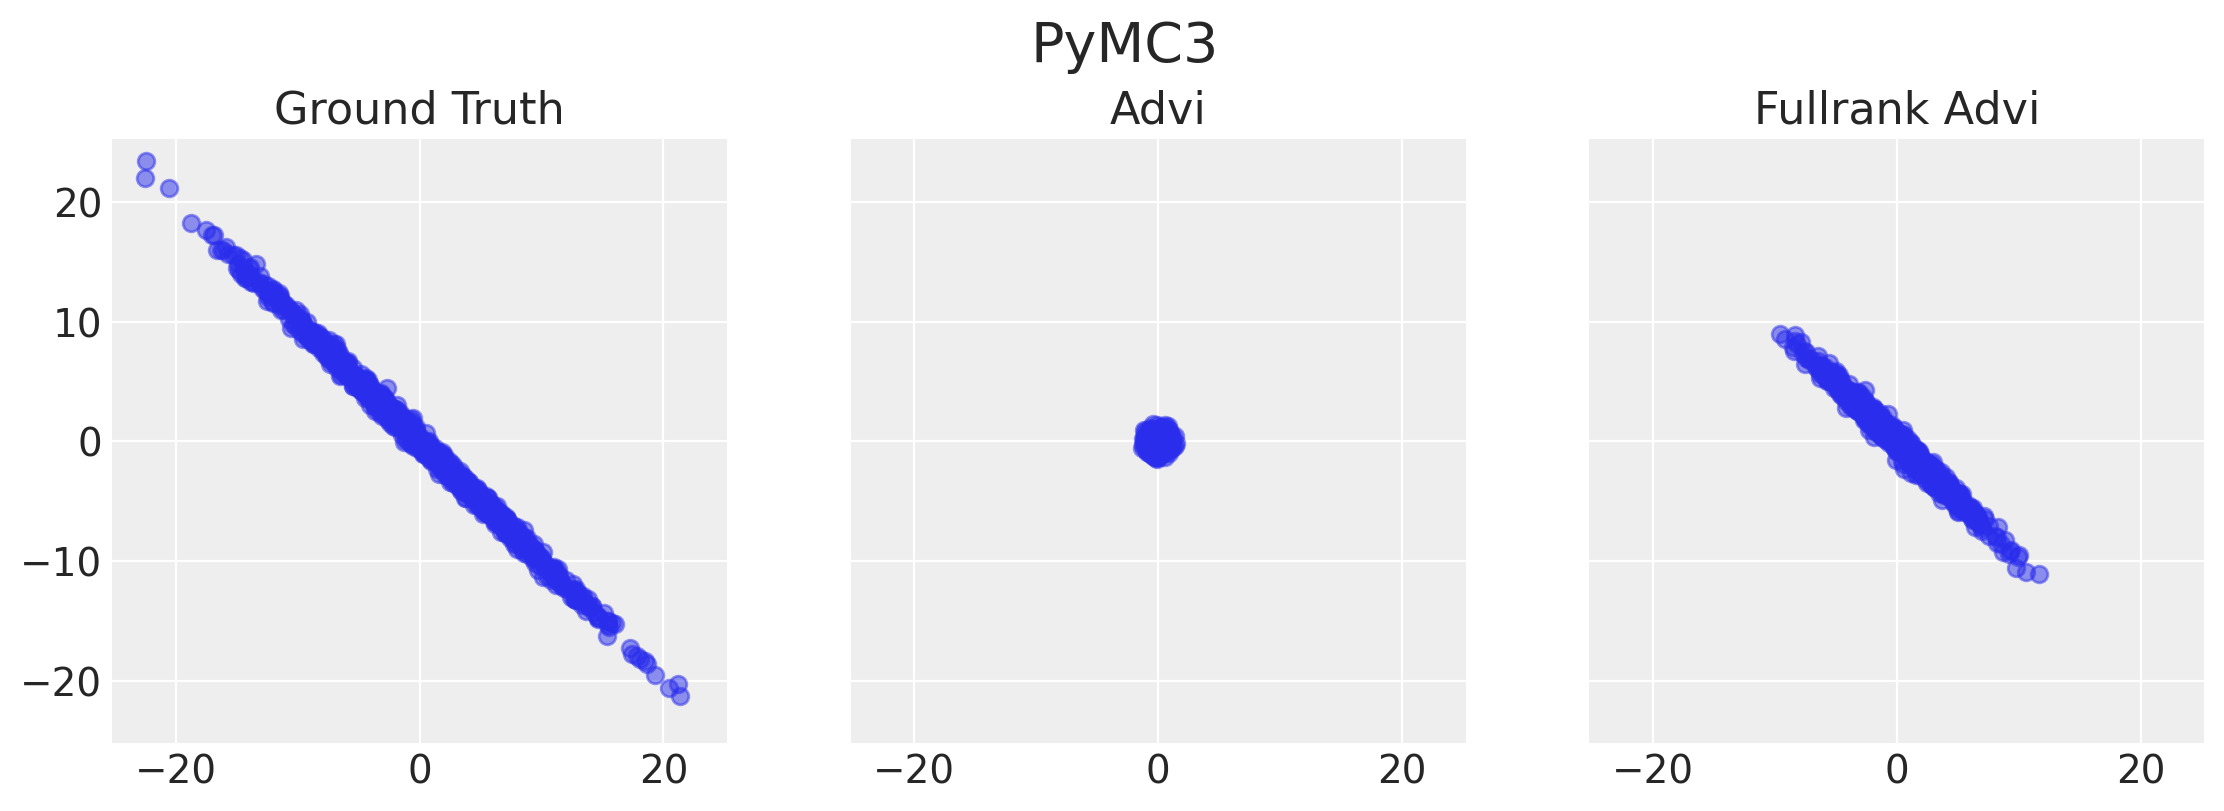

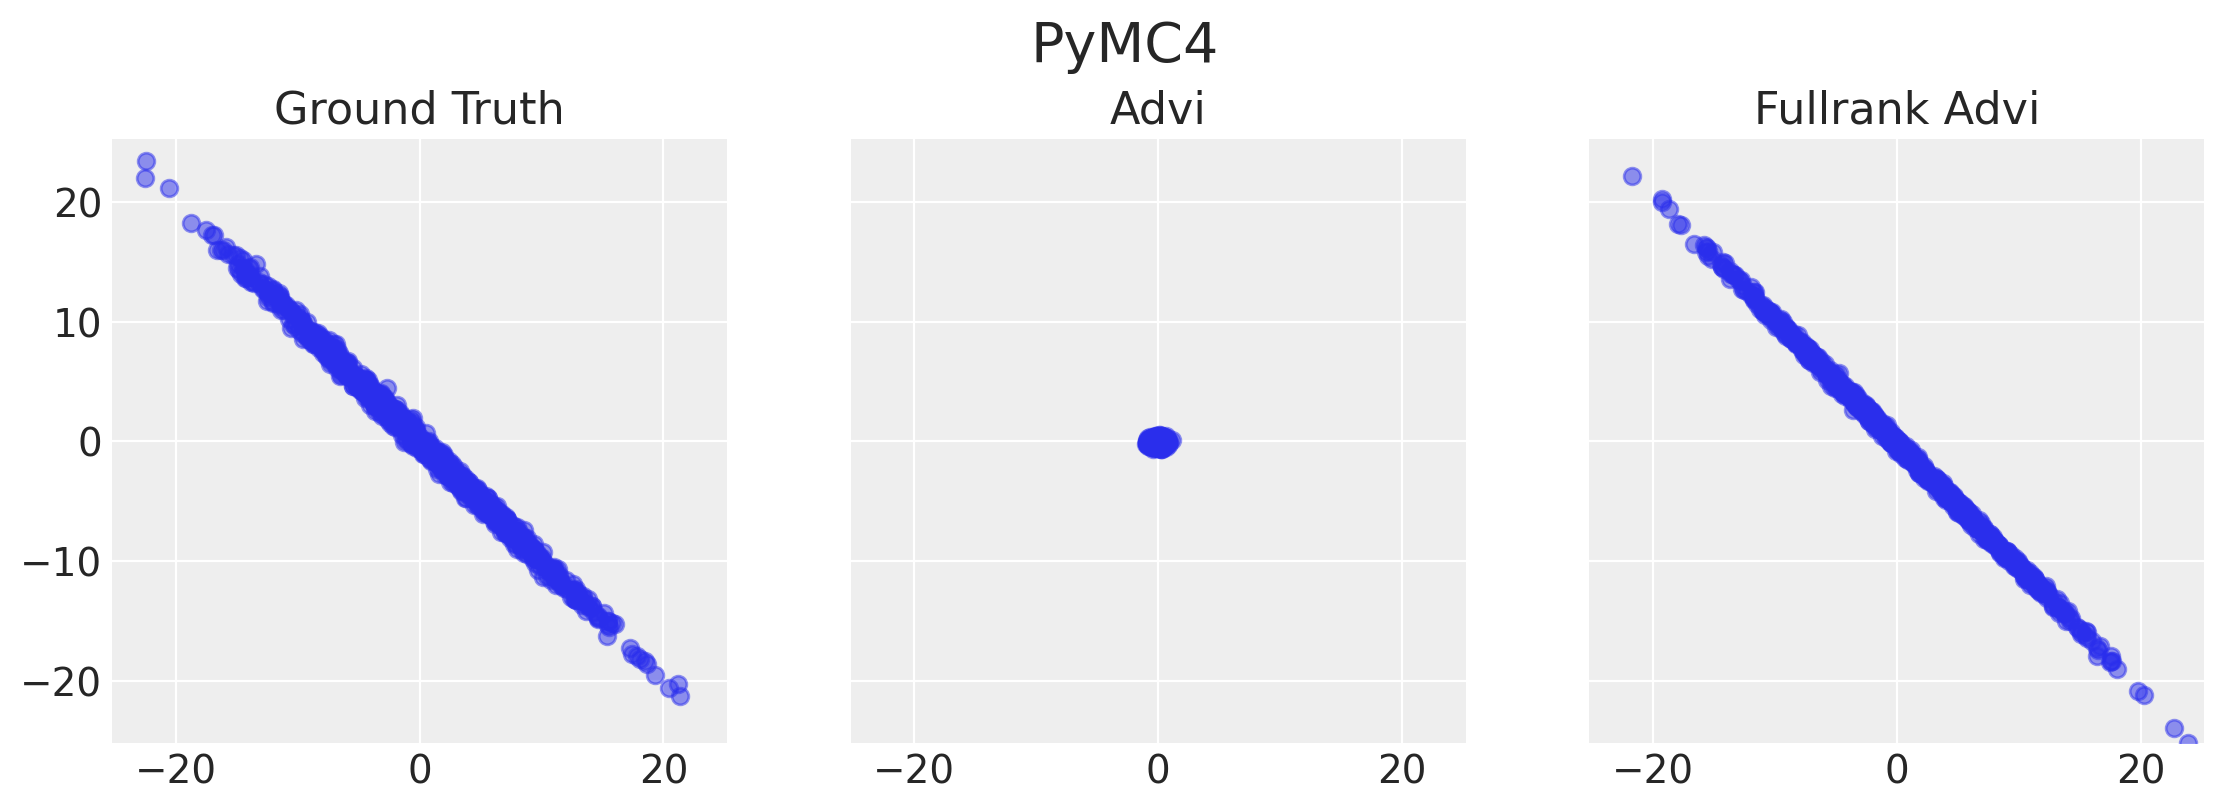

In [11]:
# Plots

bounds = get_bounds(pm3_samples, pm4_samples)
plot_approx('PyMC3', pm3_samples, bounds)
plot_approx('PyMC4', pm4_samples, bounds)

## TODO - Complete the Mixtures comparison